# Explaination

I want to split training/test/validation sets such that:
- the three sets of data keep approx the same percentage of interaction and not-interaction pairs
- there is a consistent number of genes that differs between the 3 sets of data (so that, in the inference phase, we reduce performance over-estimation due to potential auto-correlations among different observations pertaining to the same transcript).
- we approximately keep the same percentage of protein_coding-protein_coding, protein_coding-non_protein_coding, non_protein_coding-non_protein_coding interactions in the three sets.
- we approximately keep the same percentage of human and mouse species in the three sets.
- we approximately keep the same percentage of the different cell lines in the three sets.
- we obtain comparable matrix areas in the three sets.
- we obtain comparable interaction areas in the three sets.

In order to achieve these goals, we create the following algorithm.  

We observed that the dataset of unique genes has this peculiarity: there are always pairs of genes such that if you jointly pick them the number of n_interactors and n_not_interactors is approximately balanced (see example below). Because of this, our algorithm will sequentially sample 2 genes at the time (the ones that minimize the difference between the number of n_interactors and n_not_interactors).

| gene_id| n_interactors | n_not_interactors |
| --- | --- | --- |
| ENSMUSG00000108945 | 1 | 876 |
| ENSMUSG00000089855 | 880 | 5 |
| ENSMUSG00000073867 | 777 | 6 |
| ENSMUSG00000042265 | 1 | 772 |
| ENSMUSG00000097974 | 1 | 1169 |
| ENSMUSG00000097971 | 1171 | 1 |

Our algorithm can be summarized as follow: 
- We calculate N, the number of rna-rna pairs to sample in the training set, based on the percentage you provide (e.g. 70%). 
- Until the number of rna-rna pairs is < N, we sample 2 genes at the time (the reason has been explained above) and all the rna-rna pairs that involve those genes, based on a criteria. Two criterias are compared: random and loss-based. The random one picks randomly 2 genes (again, when we do this the difference between the number of n_interactors and n_not_interactors is minimal); the loss-based criteria picks 2 genes such that a Loss function (see section) is minimized. Remember that when we say "pick 2 genes" we are saying "we pick 2 genes and all the rna-rna pairs that involve those genes".
- All the remaining rna-rna pairs not sampled are considered as test set.

We perform our algorithm twice for each criteria (random and loss-based). The first time we calculate training (70%) and test+validation sets (30%); the second time we calculate test (67% of test+validation, it means 20% of the total) and validation sets (33% of test+validation, it means 10% of the total).

In the script there is also a comparison between the two criterias.

### Loss function 
The loss function to be minimized is calculated as follows:

Loss = Loss_1 + Loss_2 + mean(Loss_3 + Loss_4) + Loss_5

Each Loss_i (i=1,2,3,4,5) is calculated as follows:

Loss_1: MAE between the real value distributions VS their estimates of these features:
- percentage of protein_coding-protein_coding in the interaction pair 
- percentage of protein_coding-non_protein_coding in the interaction pair 
- percentage of non_protein_coding-non_protein_coding in the interaction pair is
- percentage of protein_coding-protein_coding in the non interaction pair
- percentage of protein_coding-non_protein_coding in the non interaction pair
- percentage of non_protein_coding-non_protein_coding in the non interaction pair

Loss_2 (only for human): MAE between the real value distributions VS their estimates of these features:
- The percentage of HEK293T in the interaction pair
- The percentage of Hela(highRNase) in the interaction pair is
- The percentage of Hela(lowRNase) in the interaction pair
- The percentage of HEK293T in the non interaction pair
- The percentage of Hela(highRNase) in the non interaction pair
- The percentage of Hela(lowRNase) in the non interaction pair

Loss_3: MAE between the probabilities in the 10 bins (whose extremes are found in the original distribution) between the real value distribution bins and the estimated distrubution bins of  area_of_the_matrix in the interaction pair

Loss_4: MAE between the probabilities in the 10 bins (whose extremes are found in the original distribution) between the real value distribution bins and the estimated distrubution bins of area_of_the_matrix in the non interaction pair

Loss_5: MAE between the probabilities in the 10 bins (whose extremes are found in the original distribution) between the real value distribution bins and the estimated distrubution bins of area_of_the_interaction in the interaction pair


# Code

In [1]:
import pandas as pd
import os
import time
import numpy as np
import argparse
import sys
sys.path.insert(0, '..')
import dataset.train_test_val_utils as utils
from pandas.core.common import SettingWithCopyWarning
import warnings
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [2]:
ROOT_DIR = os.path.dirname(os.path.abspath('.'))
original_files_dir = os.path.join(ROOT_DIR, 'dataset', 'original_files')
processed_files_dir = os.path.join(ROOT_DIR, 'dataset', 'processed_files')
rna_rna_pairs_data_dir = os.path.join(ROOT_DIR, 'dataset', 'rna_rna_pairs')

### Pre-processing

In [38]:
start_time = time.time()
df_hub = utils.read_dataframe(os.path.join(original_files_dir, 'hub.table.paris.txt'), columns_to_drop = ['Unnamed: 0','gene_name', 'method']).rename({'cell_line': 'cell_line_set',
                                                                                                                                                    'degree':'n_interactors',
                                                                                                                                                    'gene_type': 'gene_type_set',
                                                                                                                                                    'species': 'species_set'}, axis = 1)
df = utils.get_df(df_hub, processed_files_dir, original_files_dir) #it will load df from a specific path if it already exists, otherwise it will create a new one
df_int, df_con = utils.split_df_int_con(df)
df_hub = utils.create_df_hub(df_int, df_con)
print(f"Total time: {(time.time()-start_time)/60} minutes")

Total time: 0.013553488254547118 minutes


### Train-test-split algorithm

In [5]:
df_human = df[df.species == 'human'].reset_index(drop = True)
df_mouse = df[df.species == 'mouse'].reset_index(drop = True)
assert df.shape[0] == df_human.shape[0] + df_mouse.shape[0]
perc_interactors_human = df_human.there_is_interaction.value_counts()[True]/df_human.shape[0]
perc_interactors_mouse = df_mouse.there_is_interaction.value_counts()[True]/df_mouse.shape[0]
print(perc_interactors_human)
print(perc_interactors_mouse)

0.5363209170769668
0.5741551392050429


In [5]:
#start_time = time.time()
#train, test, val =  utils.create_or_load_train_test_val(df, save_path = rna_rna_pairs_data_dir)
#print(f"Total time: {(time.time()-start_time)/60} minutes")
# 121.4655 minuti per il 58% di HUMAN

In [6]:
start_time = time.time()
train_random, test_random, val_random = utils.create_or_load_train_test_val(df, save_path = rna_rna_pairs_data_dir, random = True)
print(f"Total time: {(time.time()-start_time)/60} minutes")
#Total time: 6.75 minutes

Total time: 0.009731785456339518 minutes


<AxesSubplot:>

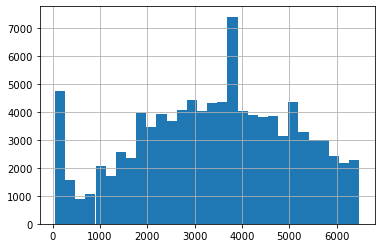

In [7]:
train_random.sort_values('length_1').head(100000).length_1.hist(bins = 30)

### Plots and criteria comparison

#### Human

In [ ]:
#train_human = train[train.species == 'human'].reset_index(drop = True)
#test_human = test[test.species == 'human'].reset_index(drop = True)
#val_human = val[val.species == 'human'].reset_index(drop = True)
#utils.plot_stats(df_human, train_human, test_human, val_human)

In [8]:
train_human_random = train_random[train_random.species == 'human'].reset_index(drop = True)
test_human_random = test_random[test_random.species == 'human'].reset_index(drop = True)
val_human_random = val_random[val_random.species == 'human'].reset_index(drop = True)

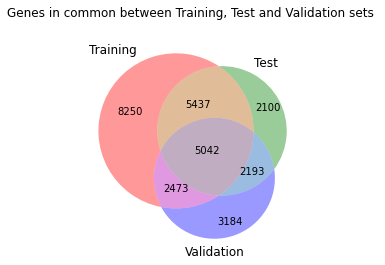

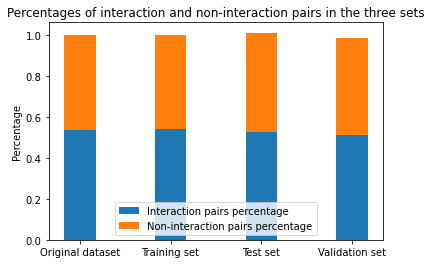

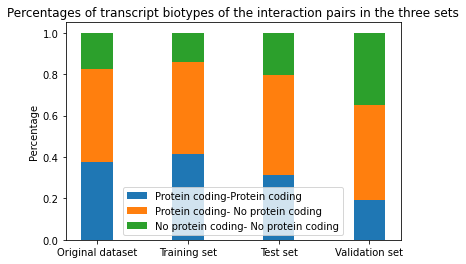

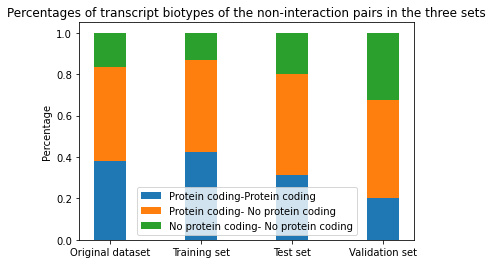

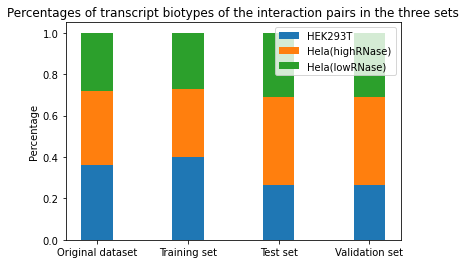

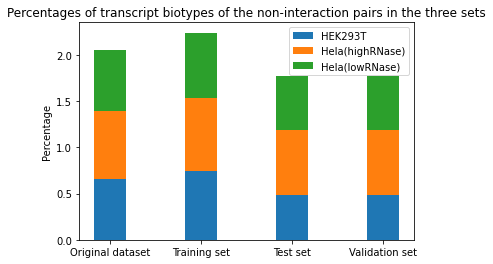

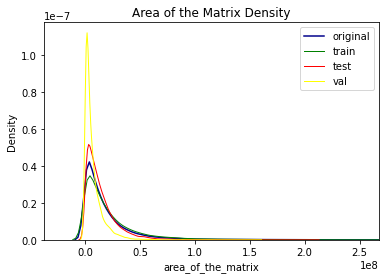

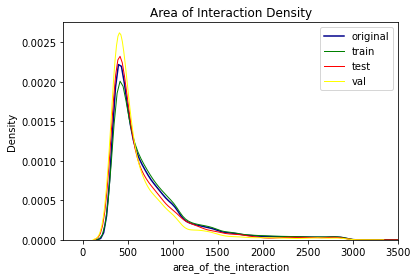

In [9]:
utils.plot_stats(df_human, train_human_random, test_human_random, val_human_random)

#### Mouse

In [10]:
#train_mouse = train[train.species == 'mouse'].reset_index(drop = True)
#test_mouse = test[test.species == 'mouse'].reset_index(drop = True)
#val_mouse = val[val.species == 'mouse'].reset_index(drop = True)
#utils.plot_stats(df_mouse, train_mouse, test_mouse, val_mouse)

In [11]:
train_mouse_random = train_random[train_random.species == 'mouse'].reset_index(drop = True)
test_mouse_random = test_random[test_random.species == 'mouse'].reset_index(drop = True)
val_mouse_random = val_random[val_random.species == 'mouse'].reset_index(drop = True)

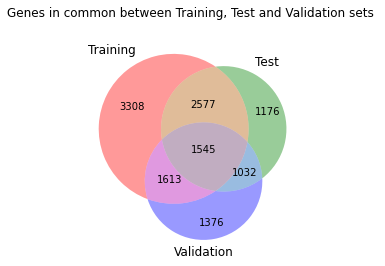

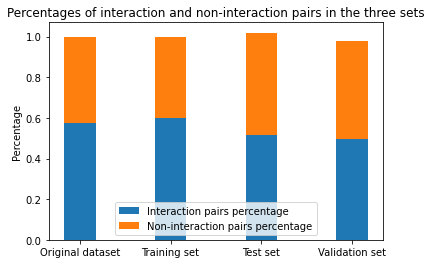

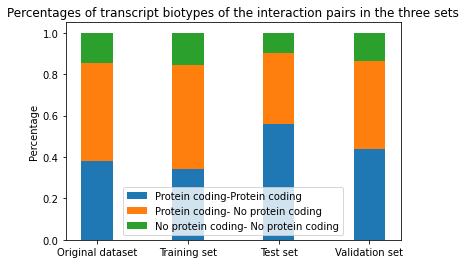

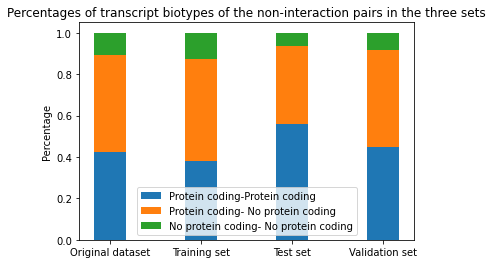

The only cell line is mES




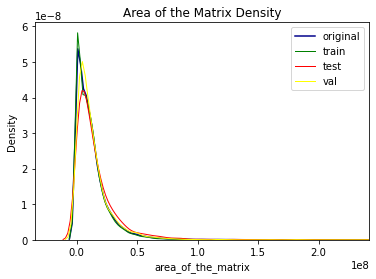

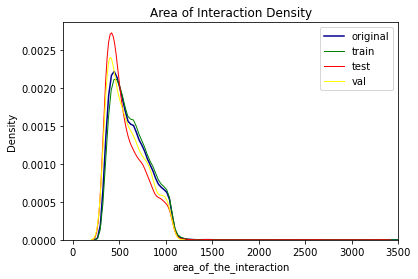

In [12]:
utils.plot_stats(df_mouse, train_mouse_random, test_mouse_random, val_mouse_random)

The two criteria seems to reproduce approximately the same results. 

# Length analysis

In [46]:
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt
import seaborn as sns

In [56]:
print(f'{df[df.there_is_interaction == False].area_of_the_matrix.mean()=}')

print(f'{df[df.there_is_interaction == True].area_of_the_matrix.mean()=}')

l_neg = pd.concat([df[df.there_is_interaction == False][['length_1']], df[df.there_is_interaction == False][['length_2']].rename({'length_2':'length_1'}, axis = 1)], axis = 0)

l_pos = pd.concat([df[df.there_is_interaction == True][['length_1']], df[df.there_is_interaction == True][['length_2']].rename({'length_2':'length_1'}, axis = 1)], axis = 0)

a_neg = df[df.there_is_interaction == False][['area_of_the_matrix']]

a_pos = df[df.there_is_interaction == True][['area_of_the_matrix']]

print(f'{float(a_neg.mean())=}')
print(f'{float(a_pos.mean())=}')

df[df.there_is_interaction == False].area_of_the_matrix.mean()=14142511.229479458
df[df.there_is_interaction == True].area_of_the_matrix.mean()=28070854.144219555
float(a_neg.mean())=14142511.229479458
float(a_pos.mean())=28070854.144219555


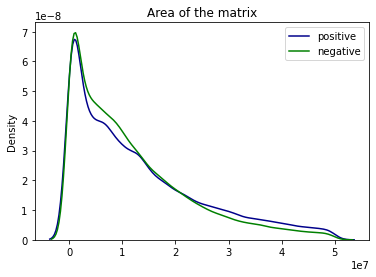

In [48]:
plt.title('Area of the matrix')
sns.kdeplot(utils.filter_series(a_pos.area_of_the_matrix, 50000000).values,color = 'darkblue', linewidth = 1.5, label='positive')
sns.kdeplot(utils.filter_series(a_neg.area_of_the_matrix, 50000000).values, color = 'green', linewidth = 1.5, label='negative')
x1,x2,y1,y2 = plt.axis()  
plt.legend()
plt.axis((x1,x2,y1,y2))
plt.show()

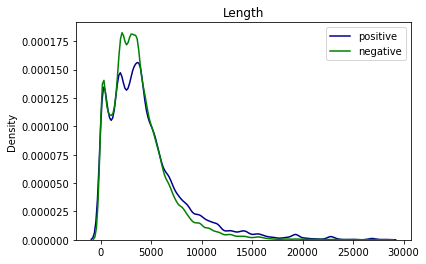

In [49]:
plt.title('Length')
sns.kdeplot(utils.filter_series(l_pos.length_1, 30000).values,color = 'darkblue', linewidth = 1.5, label='positive')
sns.kdeplot(utils.filter_series(l_neg.length_1, 30000).values, color = 'green', linewidth = 1.5, label='negative')
x1,x2,y1,y2 = plt.axis()  
plt.legend()
plt.axis((x1,x2,y1,y2))
plt.show()

In [50]:
#prepare data
df_hub1 = df_hub[['gene_id']].merge(df_int[['gene_id1', 'length_1', 'protein_coding_1', 'species']], left_on = 'gene_id', right_on = 'gene_id1' ).drop('gene_id1', axis = 1).drop_duplicates().rename({'length_1':'length', 'protein_coding_1': 'protein_coding'}, axis = 1)
df_hub2 = df_hub[['gene_id']].merge(df_int[['gene_id2', 'length_2', 'protein_coding_2', 'species']], left_on = 'gene_id', right_on = 'gene_id2' ).drop('gene_id2', axis = 1).drop_duplicates().rename({'length_2':'length', 'protein_coding_2': 'protein_coding'}, axis = 1)
df_hub_full = pd.concat([df_hub1, df_hub2], axis = 0).drop_duplicates().reset_index(drop = True)
assert df_hub_full.shape[0] == df_hub.shape[0]

print(mannwhitneyu(df_hub_full[df_hub_full.protein_coding == True].length, 
             df_hub_full[df_hub_full.protein_coding == False].length, 
            alternative = 'greater').pvalue)
print('The protein_coding rnas are longer')

print(mannwhitneyu(df_hub_full[df_hub_full.species == 'human'].length, 
             df_hub_full[df_hub_full.species == 'mouse'].length, 
            alternative = 'less').pvalue)
print('The mouse rnas are longer')

0.0
The protein_coding rnas are longer
9.82959121322685e-172
The mouse rnas are longer


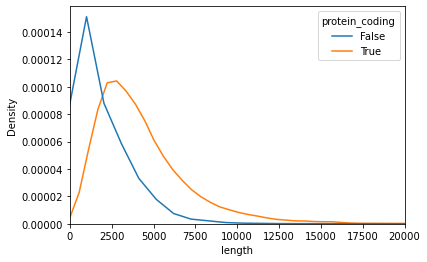

In [51]:
sns.kdeplot(data=df_hub_full, x="length", hue="protein_coding")
x1,x2,y1,y2 = plt.axis()  
plt.axis((-10,20000,y1,y2))
plt.show()

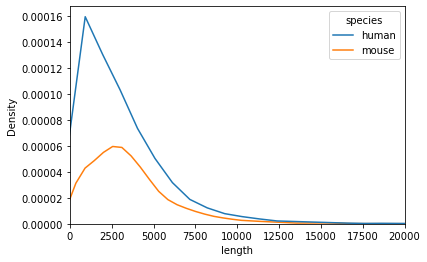

In [52]:
sns.kdeplot(data=df_hub_full, x="length", hue="species")
x1,x2,y1,y2 = plt.axis()  
plt.axis((-10,20000,y1,y2))
plt.show()